In [1]:
import json
import os
import numpy
import matplotlib.pyplot as plt 

In [2]:
def get_predictions(json_file, lf_thresh):
    filtered = []
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
            for item in data:
                # split the score and LesionFinder string to get the score and cast it to float
                score = float(item['properties']['classification']['name'].split(' ')[-1])
                if score >= lf_thresh:
                    x0, y0 = item['geometry']['coordinates'][0][0]
                    x1, y1 = item['geometry']['coordinates'][0][2]
                    x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)
                    filtered.append([x0, y0, x1, y1])
    except:
        pass    
    return filtered

def get_named_box(json_file, name):
    boxes = []
    with open(json_file, 'r') as f:
        data = json.load(f)
        for item in data:
            try:
                if item['properties']['name'] == name:
                    x0, y0 = item['geometry']['coordinates'][0][0]
                    x1, y1 = item['geometry']['coordinates'][0][2]
                    x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)
                    boxes.append([x0, y0, x1, y1])
            except:
                pass
    return boxes

def box_named_polygon(json_file, name):
    boxes = []
    with open(json_file, 'r') as f:
        data = json.load(f)
        for item in data:
            try:
                if item['properties']['classification']['name'] == name: # might be just name not classification
                    coords = item['geometry']['coordinates'][0]
                    x0 = min([x for x, y in coords])
                    y0 = min([y for x, y in coords])
                    x1 = max([x for x, y in coords])
                    y1 = max([y for x, y in coords])
                    x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)
                    boxes.append([x0, y0, x1, y1])
            except:
                pass
    return boxes

def create_mask(img_size, boxes):
    mask = numpy.zeros(img_size, dtype=numpy.uint8)
    for box in boxes:
        x0, y0, x1, y1 = box
        mask[y0:y1, x0:x1] = 1
    return mask
    
def image_iou(mask1, mask2):
    intersection = numpy.logical_and(mask1, mask2)
    union = numpy.logical_or(mask1, mask2)
    iou_score = numpy.sum(intersection) / numpy.sum(union)
    return iou_score

def gt_coverage(mask1, mask2):
    intersection = numpy.logical_and(mask1, mask2)
    coverage = numpy.sum(intersection) / numpy.sum(mask1)
    return coverage

In [3]:
gt_file = '/mnt/RSX/Datasets_pathology/SRI_OSCC_lymph_unlabeled/qupath_annotations_test/Case 27 F4.json' 
pred_file = '/mnt/RSX/Datasets_pathology/SRI_OSCC_lymph_unlabeled/lesion_finder_2000_v3/Case 27 F4.json'

gt_boxes = box_named_polygon(gt_file, 'Tumor')
pred_boxes = get_predictions(pred_file, 0.7)

x_max = max([box[2] for box in gt_boxes + pred_boxes])
y_max = max([box[3] for box in gt_boxes + pred_boxes])

gt_mask = create_mask((y_max, x_max), gt_boxes)
pred_mask = create_mask((y_max, x_max), pred_boxes)

In [4]:
print('IoU:', image_iou(gt_mask, pred_mask))
print('GT coverage:', gt_coverage(gt_mask, pred_mask))

IoU: 0.0
GT coverage: 0.0


In [5]:
primary_list = ['Case 24 F2',
'Case 24 G1',
'Case 25 B7',
'Case 25 C1',
'Case 26 B12',
'Case 27 E8',
'Case 27 F1',
'Case 28 A3',
'Case 28 B1',
'Case 29 C2',
'Case 30 J8',
'Case 31 A10',
'Case 32 A5',
'Case 33 A7',
'Case 34 A5',]

In [6]:
def get_pr_curve(gt_dir, pred_dir, name, lf_thresh, det_thresh):
    fp = []
    fn = []
    tp = []
    tn = []
    good_seg = []
    for f in os.listdir(gt_dir):
        n = f.split('.')[0]
        if n in primary_list:
            continue
        gt_file = os.path.join(gt_dir, f)
        pred_file = os.path.join(pred_dir, f)
        gt_boxes = box_named_polygon(gt_file, name)
        pred_boxes = get_predictions(pred_file, lf_thresh)
        if len(gt_boxes) == 0:
            if len(pred_boxes) > 0:
               # print('False positive for', f)
                fp.append(n)
            else:
               # print('True negative for', f)
                tn.append(n)
            continue
        if not os.path.exists(pred_file):
           # print('False negative for', f)
            fn.append(n)
            continue
        if len(pred_boxes) == 0:
           # print('False negative for', f)
            fn.append(n)
            continue
        else:
           # print('True positive for', f)
            tp.append(n)
            x_max = max([box[2] for box in gt_boxes + pred_boxes])
            y_max = max([box[3] for box in gt_boxes + pred_boxes])
            gt_mask = create_mask((y_max, x_max), gt_boxes)
            pred_mask = create_mask((y_max, x_max), pred_boxes)
            iou = image_iou(gt_mask, pred_mask)
            coverage = gt_coverage(gt_mask, pred_mask)
            if coverage > det_thresh:
              #  print('GOOD SEG!')
                good_seg.append(n)
    return fp, fn, tp, tn, good_seg

AUC: -0.10644531250000003


Text(0.5, 1.0, 'Image-wise ROC Curve for LF')

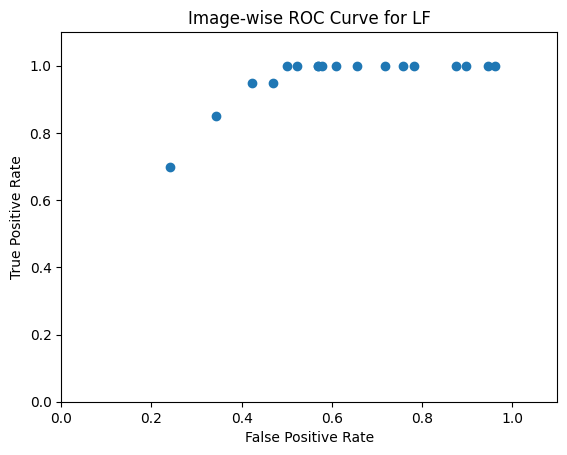

In [8]:
threshs = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
#thresh = 0.7
d_thresh = 0.5
tprs = []
fprs = []
gt_dir = '/mnt/RSX/Datasets_pathology/SRI_OSCC_lymph_unlabeled/qupath_annotations_test'
pred_dir = '/mnt/RSX/Datasets_pathology/SRI_OSCC_lymph_unlabeled/lesion_finder_2000_minthresh'
name = 'Tumor'
for thresh in threshs:
    info = get_pr_curve(gt_dir, pred_dir, name, thresh, d_thresh)
    tpr = len(info[2]) / (len(info[2]) + len(info[1]))
    fpr = len(info[0]) / (len(info[0]) + len(info[3]))
    tprs.append(tpr)
    fprs.append(fpr)
    
plt.scatter(fprs, tprs)
#calculate AUC
auc = numpy.trapz(fprs, tprs)
print('AUC:', auc)
plt.ylim(0, 1.1)
plt.xlim(0, 1.1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Image-wise ROC Curve for LF')


In [9]:
print(fprs, tprs)

[0.9609375, 0.9453125, 0.8984375, 0.875, 0.78125, 0.7578125, 0.71875, 0.65625, 0.609375, 0.578125, 0.5703125, 0.5703125, 0.5234375, 0.5, 0.46875, 0.421875, 0.34375, 0.2421875] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 0.95, 0.85, 0.7]
